In [647]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from prophet.plot import plot_cross_validation_metric
import random

In [648]:
# Import train data
ne_train = pd.read_csv("../../data/ne_train.csv")
s_train = pd.read_csv("../../data/s_train.csv")

# Import test data
ne_test = pd.read_csv("../../data/ne_test.csv")
s_test = pd.read_csv("../../data/s_test.csv")

In [649]:
ne_train_transformed = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_transformed = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [650]:
s_train_transformed = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_transformed = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [651]:
ne_train_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
ne_test_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

In [652]:
s_train_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
s_test_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

In [653]:
ne_train_plot = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_plot = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

s_train_plot = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_plot = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [654]:
ne_train_plot.set_index("date", inplace = True)
ne_test_plot.set_index("date", inplace = True)

s_train_plot.set_index("date", inplace = True)
s_test_plot.set_index("date", inplace = True)

In [655]:
# Log transform 
ne_train_transformed.y = np.log(ne_train_transformed.y)
ne_train_plot.covid_19_confirmed_cases = np.log(ne_train_plot.covid_19_confirmed_cases)
s_train_transformed.y = np.log(s_train_transformed.y)
s_train_plot.covid_19_confirmed_cases = np.log(s_train_plot.covid_19_confirmed_cases)

# Prophet Model
- Model time series data as a combination of trend, seasonality, and noise components

## Normal Prophet
- Both models performed  worse than ARIMA and AutoARIMA models
- NE: MAE on test data = 3196 confirmed cases
    - Changepoints correctly captured by the standard model --> add more changepoints
- S: MAE on test data = 26647 confirmed cases

### NE Region

In [630]:
ne_normal_prophet = Prophet()

In [631]:
ne_normal_prophet.fit(ne_train_transformed)

11:13:11 - cmdstanpy - INFO - Chain [1] start processing
11:13:11 - cmdstanpy - INFO - Chain [1] done processing


In [632]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_test_transformed.shape[0])

In [633]:
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

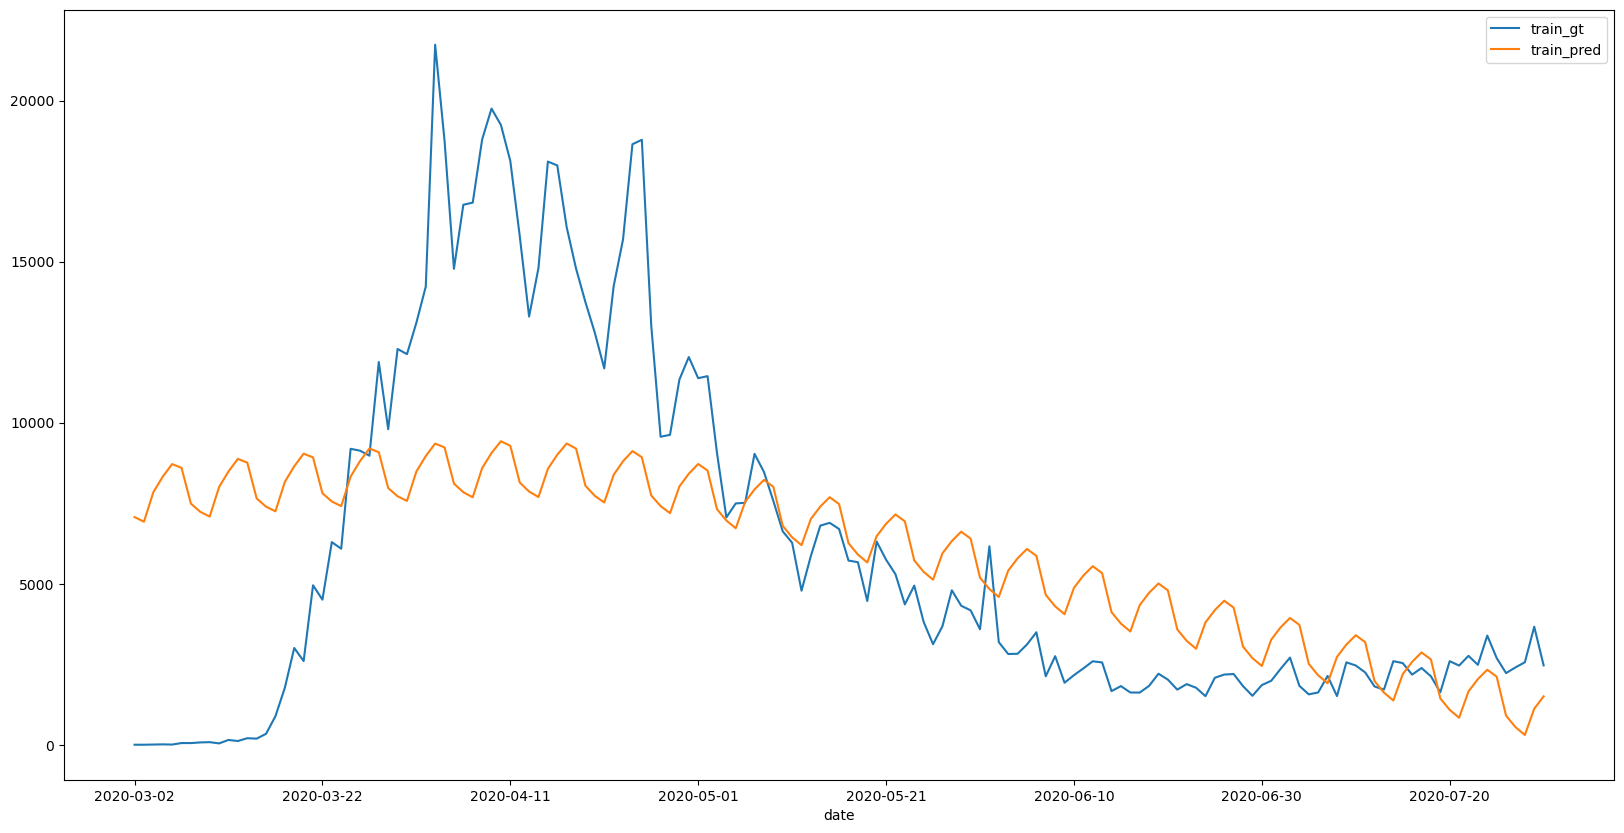

In [634]:
# Visualizing train data fitted values
ne_train_pred = ne_normal_forecast.iloc[:151]["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

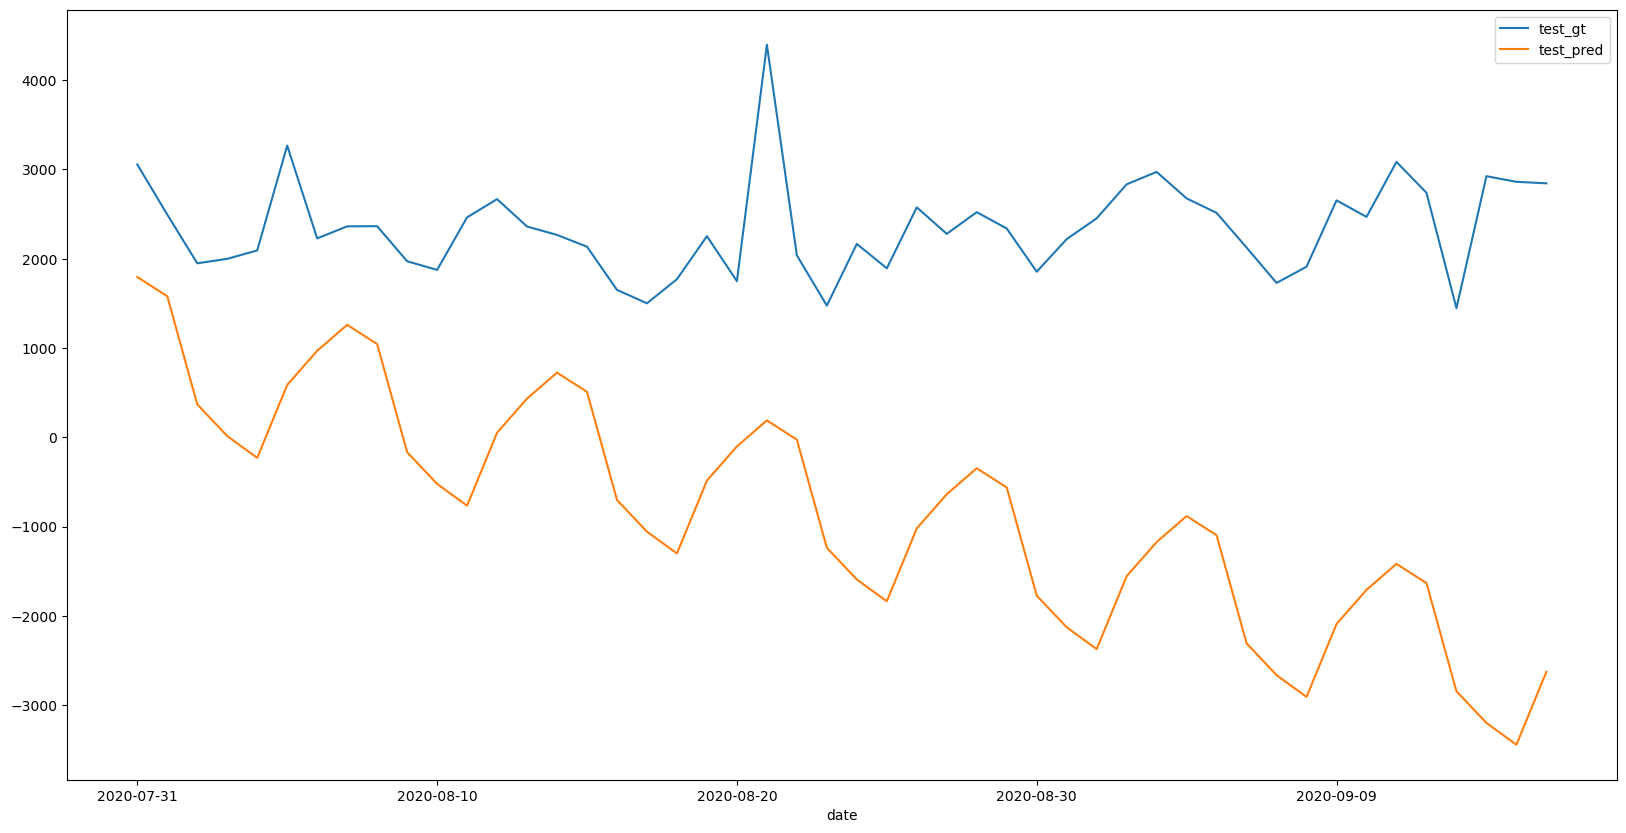

In [636]:
# Visualizing test data fitted values
ne_test_pred = ne_normal_forecast.iloc[151:]["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [637]:
# MAE on test data
mean_absolute_error(ne_test_plot, ne_test_pred)

3196.0898131578956

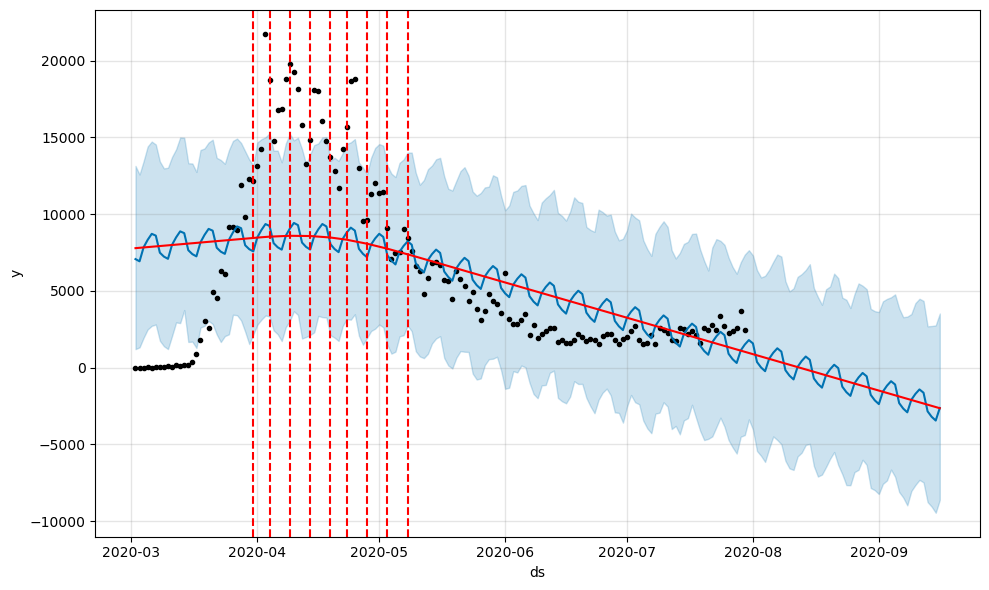

In [638]:
# Visualizing change points
fig = ne_normal_prophet.plot(ne_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_normal_prophet, ne_normal_forecast)

### S Region

In [639]:
s_normal_prophet = Prophet()

In [640]:
s_normal_prophet.fit(s_train_transformed)

11:13:24 - cmdstanpy - INFO - Chain [1] start processing
11:13:24 - cmdstanpy - INFO - Chain [1] done processing


In [641]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_test_transformed.shape[0])

In [642]:
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

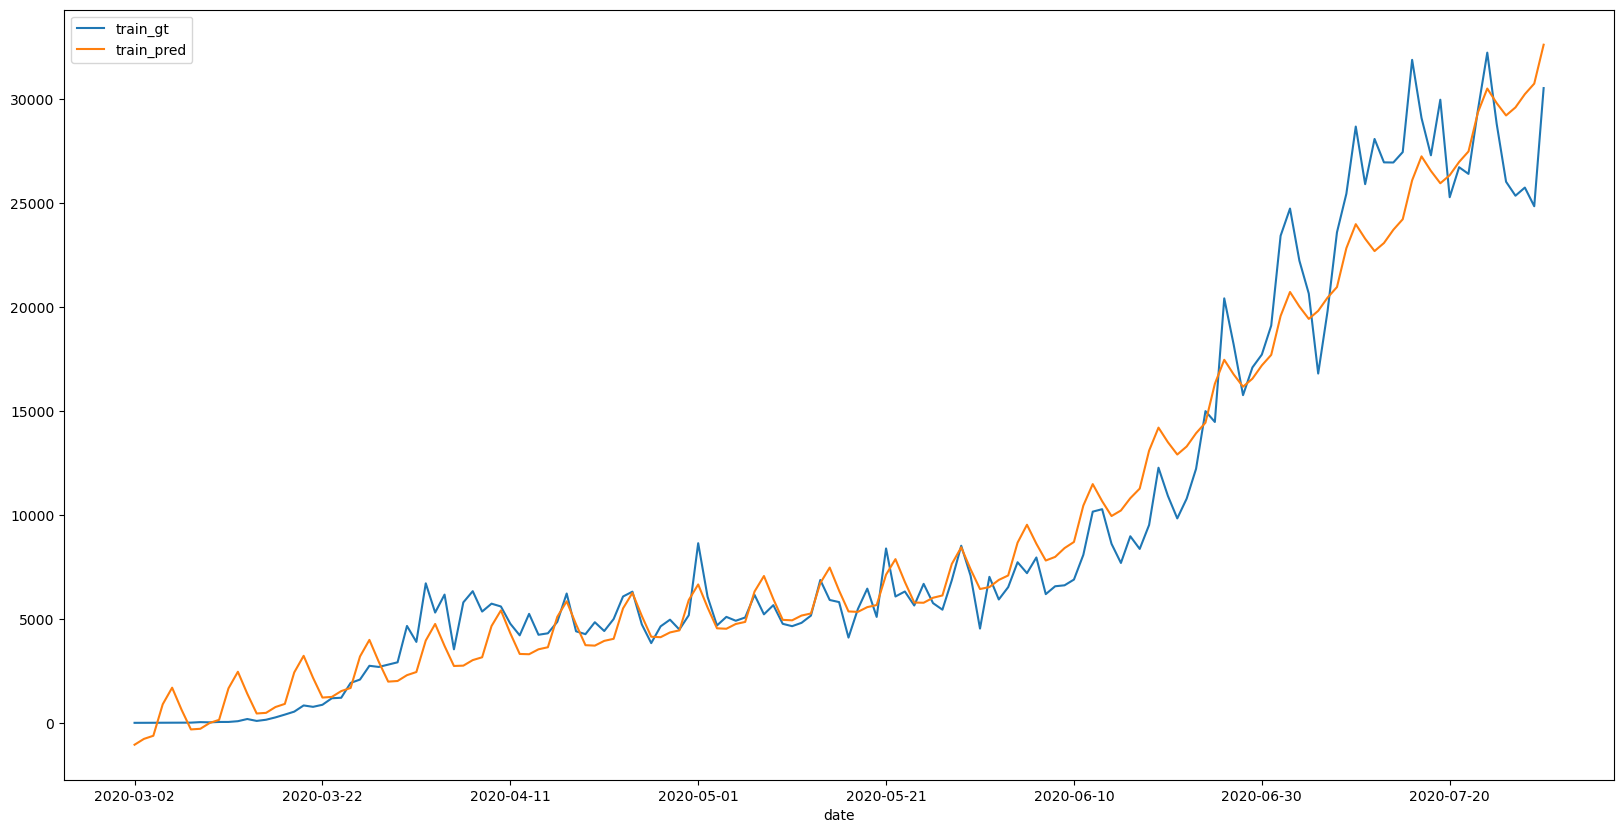

In [643]:
# Visualizing train data fitted values
s_train_pred = s_normal_forecast.iloc[:151]["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

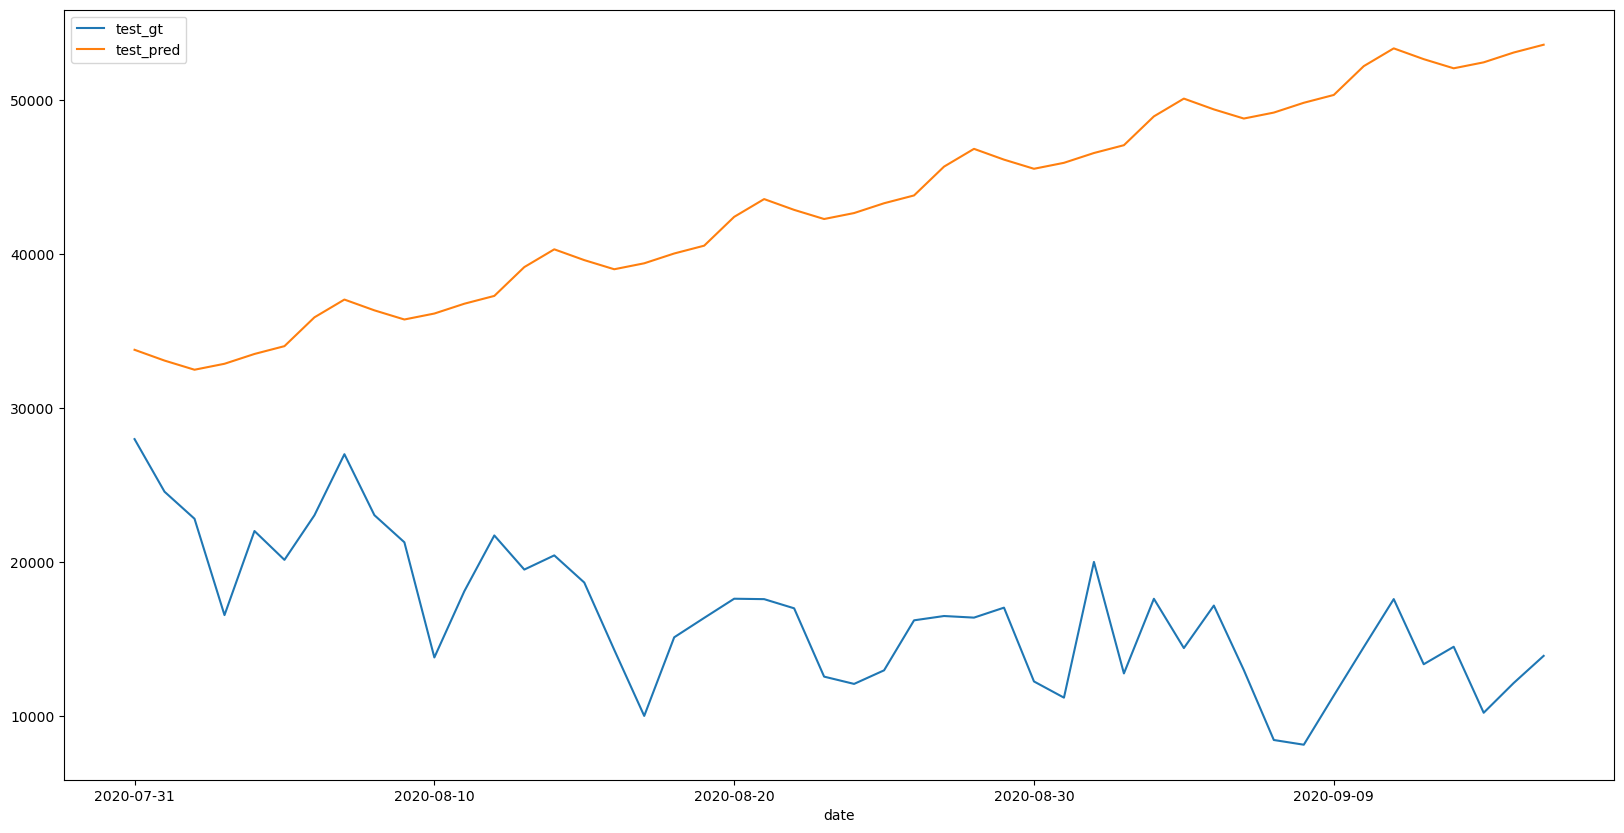

In [644]:
# Visualizing test data fitted values
s_test_pred = s_normal_forecast.iloc[151:]["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [645]:
# MAE on test data
mean_absolute_error(s_test_plot, s_test_pred)

26646.907881599942

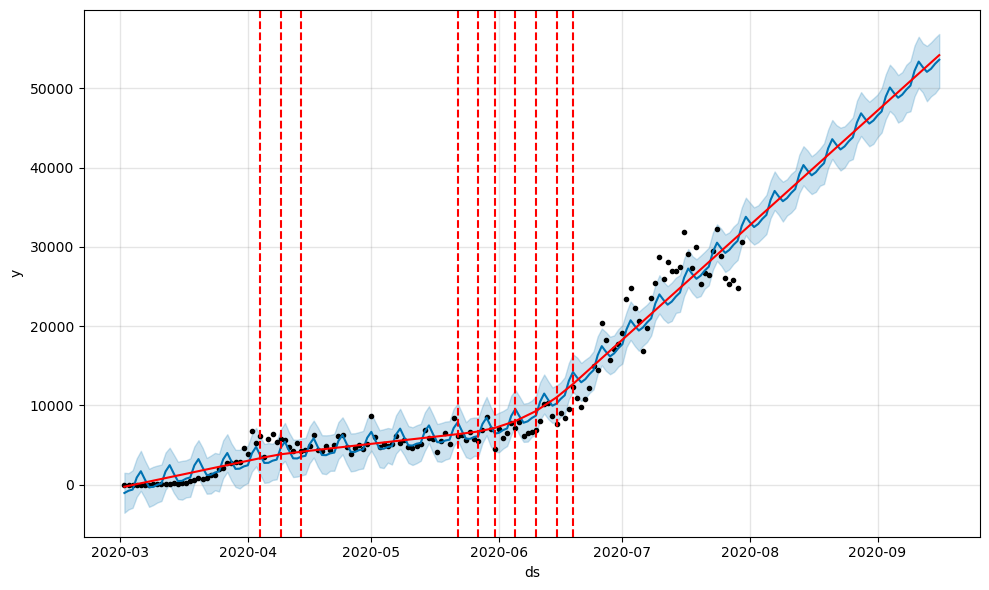

In [646]:
# Visualizing change points
fig = s_normal_prophet.plot(s_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), s_normal_prophet, s_normal_forecast)

## Tuned Prophet
- Change changepoint proportion (Prophet has automatic 25 change points, which are uniformly placed in the first 80% of the time series)
    - This is the proportion of the history in which the trend is allowed to change
    - This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series
    - Change for S region only
    - changepoint_range
- Make trends more flexible --> capture later trends in the test set
    - changepoint_prior_scale=0.5
- Control the flexibility of the seasonality
    - seasonality_prior_scale
    - A large value allows the seasonality to fit large fluctuations
    - A small value shrinks the magnitude of the seasonality
- Add built-in US holidays

### Using Cross-Validation
- The initial model will be trained on the first 90 days of data
- It will forecast the next 30 days of data
- The model will then train on the initial period + the period (90 + 15 days) and forecast the next 30 days

### Results
- NE: MAE on test data = 1830 confirmed cases
- S: MAE on tetst data = 10508 confirmed cases

### NE Region

In [656]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.85, 0.9, 0.95]
}

In [657]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
ne_maes = []

In [658]:
# Randomly choose 50 combinations
to_tune = random.sample(all_params, 50)

In [659]:
# Use cross validation to evaluate all parameters
for params in to_tune:
    ne_tuned_prophet = Prophet(**params)
    ne_tuned_prophet.add_country_holidays(country_name='US')
    ne_tuned_prophet.fit(ne_train_transformed) 
    
    df_cv = cross_validation(ne_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    ne_maes.append(df_p["mae"].values[0])

11:15:19 - cmdstanpy - INFO - Chain [1] start processing
11:15:19 - cmdstanpy - INFO - Chain [1] done processing
11:15:20 - cmdstanpy - INFO - Chain [1] start processing
11:15:20 - cmdstanpy - INFO - Chain [1] start processing
11:15:20 - cmdstanpy - INFO - Chain [1] start processing
11:15:20 - cmdstanpy - INFO - Chain [1] done processing
11:15:20 - cmdstanpy - INFO - Chain [1] done processing
11:15:20 - cmdstanpy - INFO - Chain [1] done processing
11:15:20 - cmdstanpy - INFO - Chain [1] start processing
11:15:21 - cmdstanpy - INFO - Chain [1] done processing
11:15:21 - cmdstanpy - INFO - Chain [1] start processing
11:15:21 - cmdstanpy - INFO - Chain [1] start processing
11:15:21 - cmdstanpy - INFO - Chain [1] start processing
11:15:21 - cmdstanpy - INFO - Chain [1] done processing
11:15:21 - cmdstanpy - INFO - Chain [1] done processing
11:15:22 - cmdstanpy - INFO - Chain [1] done processing
11:15:22 - cmdstanpy - INFO - Chain [1] start processing
11:15:22 - cmdstanpy - INFO - Chain [1]

11:15:30 - cmdstanpy - INFO - Chain [1] start processing
11:15:30 - cmdstanpy - INFO - Chain [1] done processing
11:15:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:15:30 - cmdstanpy - INFO - Chain [1] start processing
11:15:30 - cmdstanpy - INFO - Chain [1] done processing
11:15:31 - cmdstanpy - INFO - Chain [1] start processing
11:15:31 - cmdstanpy - INFO - Chain [1] start processing
11:15:31 - cmdstanpy - INFO - Chain [1] done processing
11:15:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:15:31 - cmdstanpy - INFO - Chain [1] start processing
11:15:31 - cmdstanpy - INFO - Chain [1] start processing
11:15:31 - cmdstanpy - INFO - Chain [1] done processing
11:15:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated ab

11:15:41 - cmdstanpy - INFO - Chain [1] start processing
11:15:41 - cmdstanpy - INFO - Chain [1] done processing
11:15:41 - cmdstanpy - INFO - Chain [1] start processing
11:15:41 - cmdstanpy - INFO - Chain [1] start processing
11:15:41 - cmdstanpy - INFO - Chain [1] start processing
11:15:41 - cmdstanpy - INFO - Chain [1] done processing
11:15:41 - cmdstanpy - INFO - Chain [1] done processing
11:15:42 - cmdstanpy - INFO - Chain [1] done processing
11:15:42 - cmdstanpy - INFO - Chain [1] start processing
11:15:42 - cmdstanpy - INFO - Chain [1] done processing
11:15:42 - cmdstanpy - INFO - Chain [1] start processing
11:15:42 - cmdstanpy - INFO - Chain [1] start processing
11:15:42 - cmdstanpy - INFO - Chain [1] done processing
11:15:42 - cmdstanpy - INFO - Chain [1] start processing
11:15:42 - cmdstanpy - INFO - Chain [1] done processing
11:15:43 - cmdstanpy - INFO - Chain [1] done processing
11:15:43 - cmdstanpy - INFO - Chain [1] start processing
11:15:43 - cmdstanpy - INFO - Chain [1]

11:15:56 - cmdstanpy - INFO - Chain [1] done processing
11:15:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:56 - cmdstanpy - INFO - Chain [1] done processing
11:15:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:56 - cmdstanpy - INFO - Chain [1] start processing
11:15:56 - cmdstanpy - INFO - Chain [1] done processing
11:15:56 - cmdstanpy - INFO - Chain [1] done processing
11:15:57 - cmdstanpy - INFO - Chain [1] done processing
11:15:57 - cmdstanpy - INFO - Chain [1] start processing
11:15:57 - cmdstanpy - INFO - Chain [1] done processing
11:15:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:15:57 - cmdstanpy - INFO - Chain [1] start processing
11:15:57 - cmdstanpy - INFO - Chain [1] done processing
11:15:58 - cmdstanpy - INFO - Chain [1] start processing
11:15:58 - cmdstanpy - INFO - Chain [1] start process

11:16:09 - cmdstanpy - INFO - Chain [1] done processing
11:16:09 - cmdstanpy - INFO - Chain [1] start processing
11:16:09 - cmdstanpy - INFO - Chain [1] done processing
11:16:09 - cmdstanpy - INFO - Chain [1] start processing
11:16:09 - cmdstanpy - INFO - Chain [1] start processing
11:16:09 - cmdstanpy - INFO - Chain [1] start processing
11:16:09 - cmdstanpy - INFO - Chain [1] done processing
11:16:09 - cmdstanpy - INFO - Chain [1] done processing
11:16:10 - cmdstanpy - INFO - Chain [1] done processing


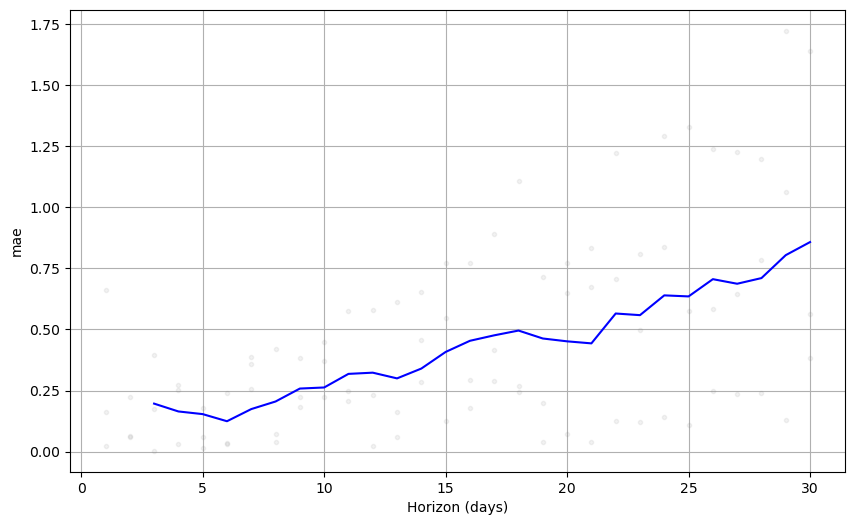

In [660]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [661]:
# Find the best parameters
tuning_results = pd.DataFrame(to_tune)
tuning_results["mae"] = ne_maes

In [662]:
tuning_results = tuning_results.sort_values(by = "mae")
tuning_results.reset_index(inplace = True, drop = True)

In [663]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,mae
0,0.500,1.00,1.00,multiplicative,0.90,0.160196
1,0.500,0.10,1.00,multiplicative,0.90,0.160505
2,0.500,10.00,1.00,additive,0.90,0.161330
3,0.500,0.10,0.01,additive,0.90,0.161698
4,0.500,0.01,0.10,multiplicative,0.95,0.170352
5,0.500,0.01,0.01,multiplicative,0.95,0.171228
6,0.500,0.10,0.01,additive,0.95,0.173876
7,0.500,1.00,0.01,multiplicative,0.85,0.196292
8,0.500,10.00,10.00,multiplicative,0.85,0.197245
9,0.500,0.10,10.00,additive,0.85,0.198118


In [664]:
# Find the best hyperparameter
best_params = to_tune[np.argmin(ne_maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


### NE Region Model

In [665]:
# Model on best params
ne_tuned_prophet = Prophet(**best_params)
ne_tuned_prophet.add_country_holidays(country_name='US')

In [666]:
ne_tuned_prophet.fit(ne_train_transformed) 

11:16:10 - cmdstanpy - INFO - Chain [1] start processing
11:16:10 - cmdstanpy - INFO - Chain [1] done processing


In [667]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_test_transformed.shape[0])

In [668]:
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

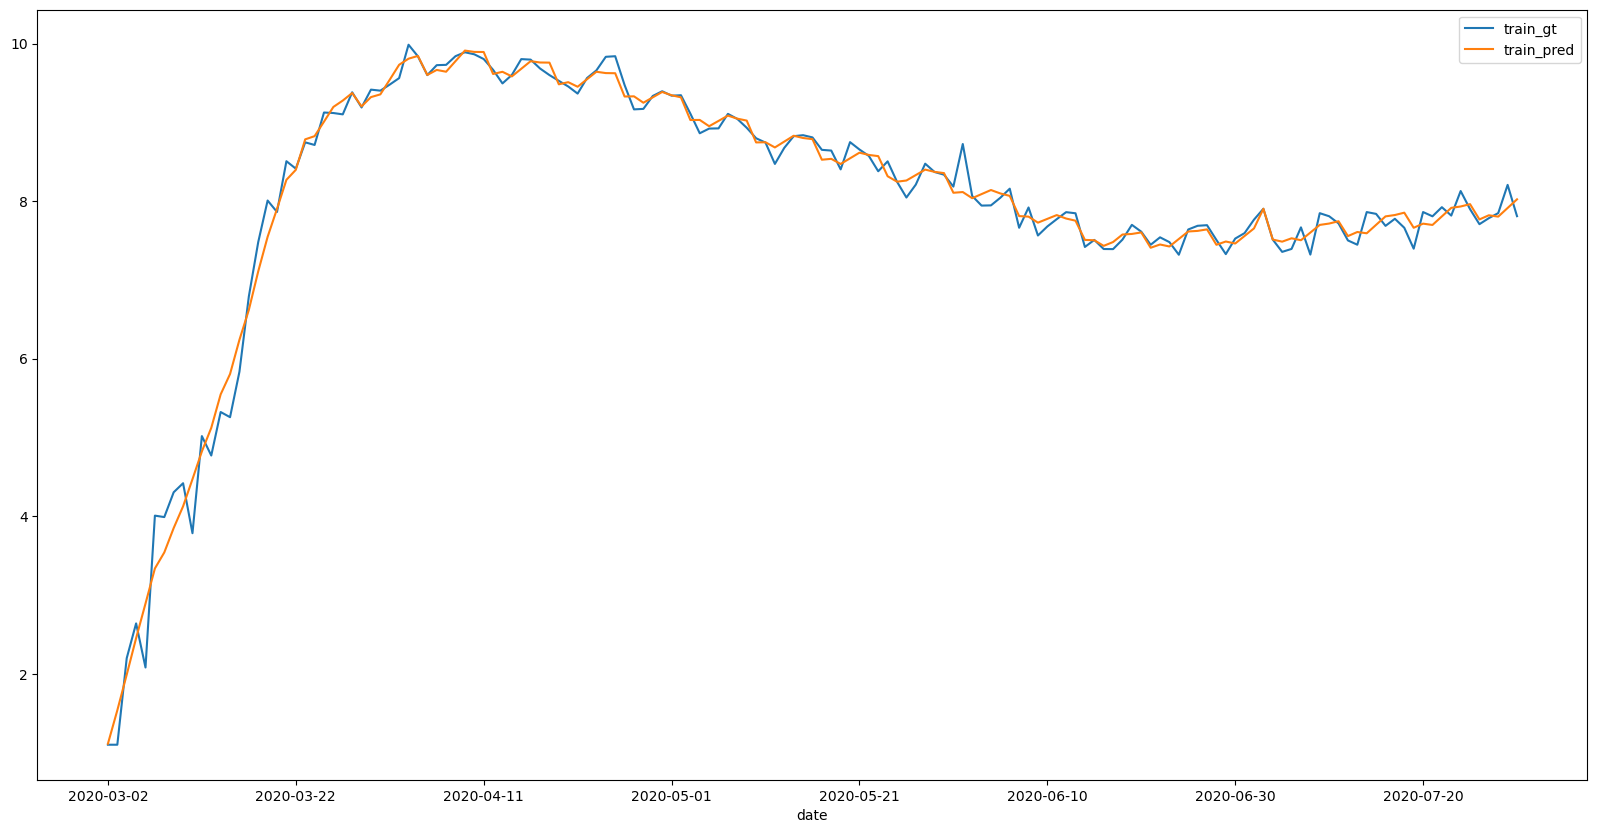

In [669]:
# Visualizing train data fitted values
ne_train_pred = ne_tuned_forecast.iloc[:151]["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

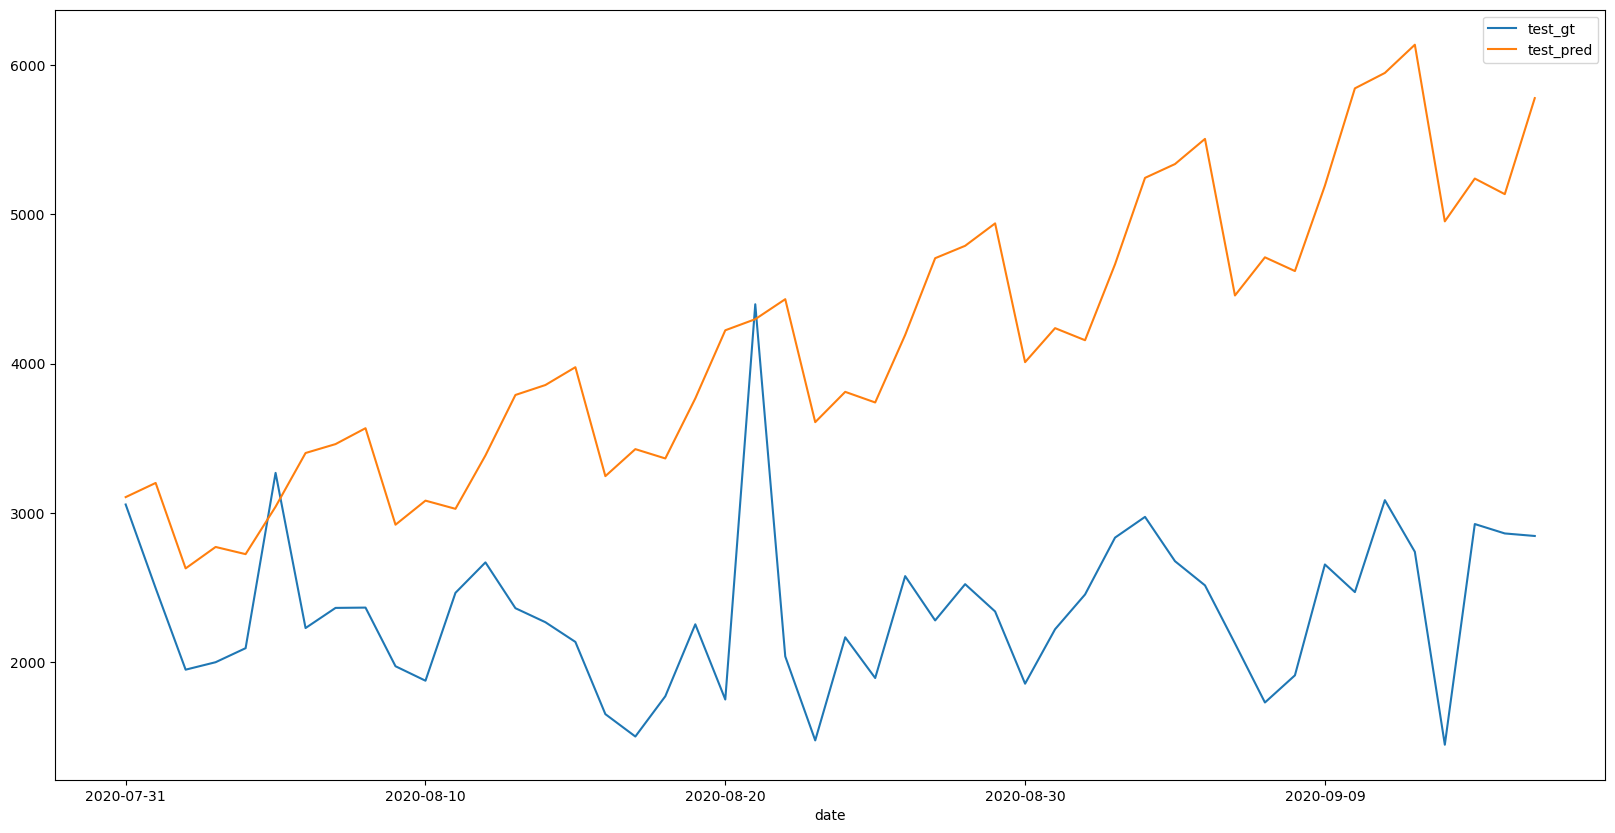

In [670]:
# Visualizing test data fitted values
ne_test_pred = ne_tuned_forecast.iloc[151:]["yhat"]
ne_test_pred = np.exp(ne_test_pred)
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [671]:
# MAE on test data
mean_absolute_error(ne_test_plot, ne_test_pred)

1829.8883213187912

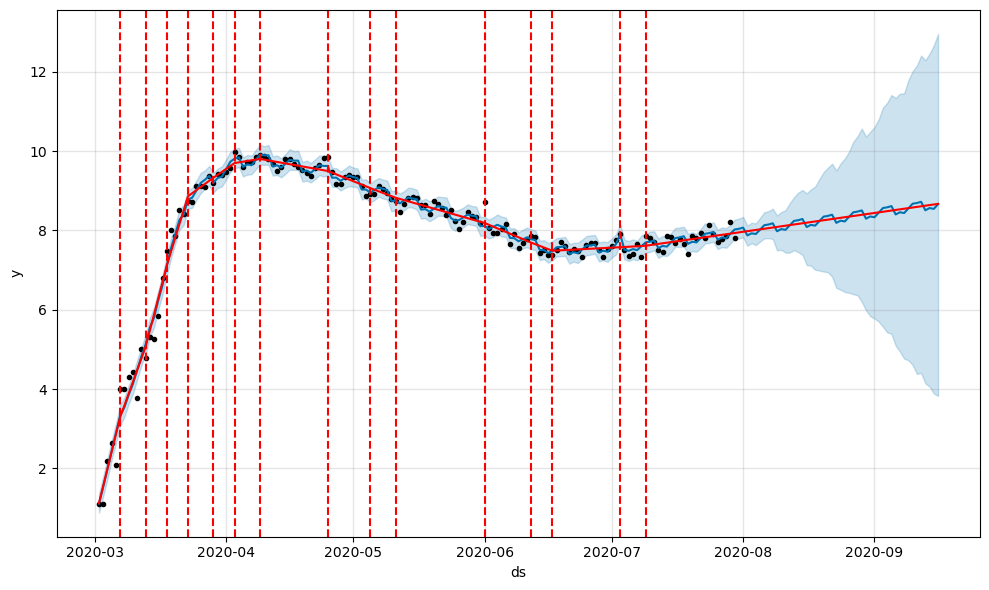

In [672]:
# Visualizing change points
fig = ne_tuned_prophet.plot(ne_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_tuned_prophet, ne_tuned_forecast)

### S Region

In [673]:
s_maes = []

In [674]:
# Use cross validation to evaluate all parameters
for params in to_tune:
    s_tuned_prophet = Prophet(**params)
    s_tuned_prophet.add_country_holidays(country_name='US')
    s_tuned_prophet.fit(s_train_transformed) 
    
    df_cv = cross_validation(s_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    s_maes.append(df_p["mae"].values[0])

11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:11 - cmdstanpy - INFO - Chain [1] done processing
11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:11 - cmdstanpy - INFO - Chain [1] done processing
11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:11 - cmdstanpy - INFO - Chain [1] done processing
11:16:11 - cmdstanpy - INFO - Chain [1] done processing
11:16:12 - cmdstanpy - INFO - Chain [1] start processing
11:16:12 - cmdstanpy - INFO - Chain [1] done processing
11:16:12 - cmdstanpy - INFO - Chain [1] start processing
11:16:12 - cmdstanpy - INFO - Chain [1] start processing
11:16:12 - cmdstanpy - INFO - Chain [1] start processing
11:16:12 - cmdstanpy - INFO - Chain [1] done processing
11:16:12 - cmdstanpy - INFO - Chain [1] done processing
11:16:12 - cmdstanpy - INFO - Chain [1] done processing
11:16:13 - cmdstanpy - INFO - Chain [1] start processing
11:16:13 - cmdstanpy - INFO - Chain [1]

11:16:22 - cmdstanpy - INFO - Chain [1] start processing
11:16:22 - cmdstanpy - INFO - Chain [1] done processing
11:16:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:16:22 - cmdstanpy - INFO - Chain [1] start processing
11:16:22 - cmdstanpy - INFO - Chain [1] done processing
11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:23 - cmdstanpy - INFO - Chain [1] done processing
11:16:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:23 - cmdstanpy - INFO - Chain [1] start processing
11:16:23 - cmdstanpy - INFO - Chain [1] done processing
11:16:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated ab

11:16:35 - cmdstanpy - INFO - Chain [1] done processing
11:16:35 - cmdstanpy - INFO - Chain [1] start processing
11:16:35 - cmdstanpy - INFO - Chain [1] done processing
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
11:16:36 - cmdstanpy - INFO - Chain [1] done processing
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
11:16:36 - cmdstanpy - INFO - Chain [1] done processing
11:16:36 - cmdstanpy - INFO - Chain [1] done processing
11:16:36 - cmdstanpy - INFO - Chain [1] start processing
11:16:36 - cmdstanpy - INFO - Chain [1] done processing
11:16:37 - cmdstanpy - INFO - Chain [1] start processing
11:16:37 - cmdstanpy - INFO - Chain [1] start processing
11:16:37 - cmdstanpy - INFO - Chain [1] done processing
11:16:37 - cmdstanpy - INFO - Chain [1] start processing
11:16:37 - cmdstanpy - INFO - Chain [1] done processing
11:16:37 - cmdstanpy - INFO - Chain [1] done processing
11:16:37 - cmdstanpy - INFO - Chain [1] 

11:16:49 - cmdstanpy - INFO - Chain [1] done processing
11:16:49 - cmdstanpy - INFO - Chain [1] start processing
11:16:49 - cmdstanpy - INFO - Chain [1] done processing
11:16:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:16:49 - cmdstanpy - INFO - Chain [1] start processing
11:16:50 - cmdstanpy - INFO - Chain [1] done processing
11:16:50 - cmdstanpy - INFO - Chain [1] start processing
11:16:50 - cmdstanpy - INFO - Chain [1] start processing
11:16:50 - cmdstanpy - INFO - Chain [1] done processing
11:16:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:16:50 - cmdstanpy - INFO - Chain [1] start processing
11:16:50 - cmdstanpy - INFO - Chain [1] start processing
11:16:50 - cmdstanpy - INFO - Chain [1] done processing
11:16:50 - cmdstanpy - ERROR - Chain [1] error: error during proce

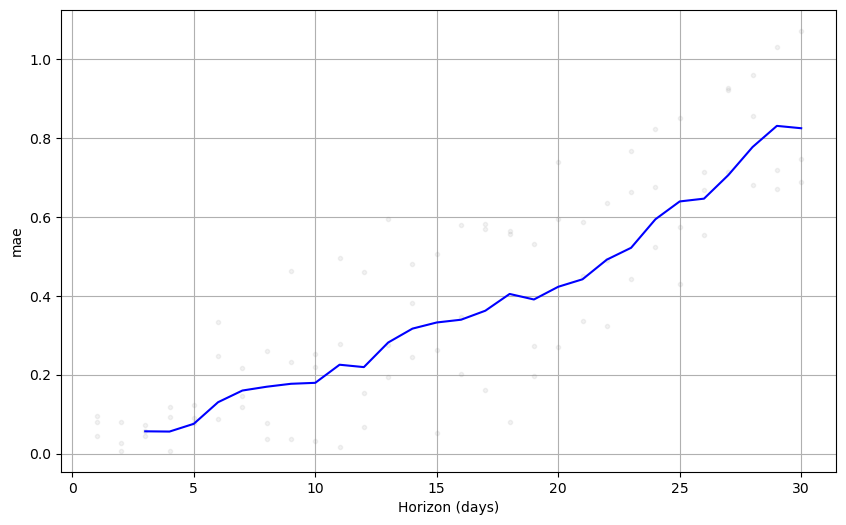

In [675]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [676]:
# Find the best parameters
tuning_results = pd.DataFrame(to_tune)
tuning_results["mae"] = s_maes

In [677]:
tuning_results = tuning_results.sort_values(by = "mae")
tuning_results.reset_index(inplace = True, drop = True)

In [678]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,changepoint_range,mae
0,0.500,0.10,0.01,additive,0.95,0.054768
1,0.500,0.10,0.01,additive,0.90,0.055553
2,0.500,1.00,0.01,multiplicative,0.85,0.056282
3,0.500,10.00,1.00,additive,0.90,0.057136
4,0.500,10.00,10.00,multiplicative,0.85,0.058830
5,0.500,10.00,0.01,additive,0.85,0.060149
6,0.500,0.10,10.00,additive,0.85,0.061390
7,0.500,0.01,0.01,multiplicative,0.95,0.066922
8,0.500,1.00,1.00,multiplicative,0.90,0.069639
9,0.500,0.01,0.10,multiplicative,0.95,0.070089


In [679]:
# Find the best hyperparameter
best_params = to_tune[np.argmin(s_maes)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


### S Region Model

In [680]:
# Model on best params
s_tuned_prophet = Prophet(**best_params)
s_tuned_prophet.add_country_holidays(country_name='US')

In [681]:
s_tuned_prophet.fit(s_train_transformed) 

11:17:01 - cmdstanpy - INFO - Chain [1] start processing
11:17:01 - cmdstanpy - INFO - Chain [1] done processing


In [682]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_test_transformed.shape[0])

In [683]:
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

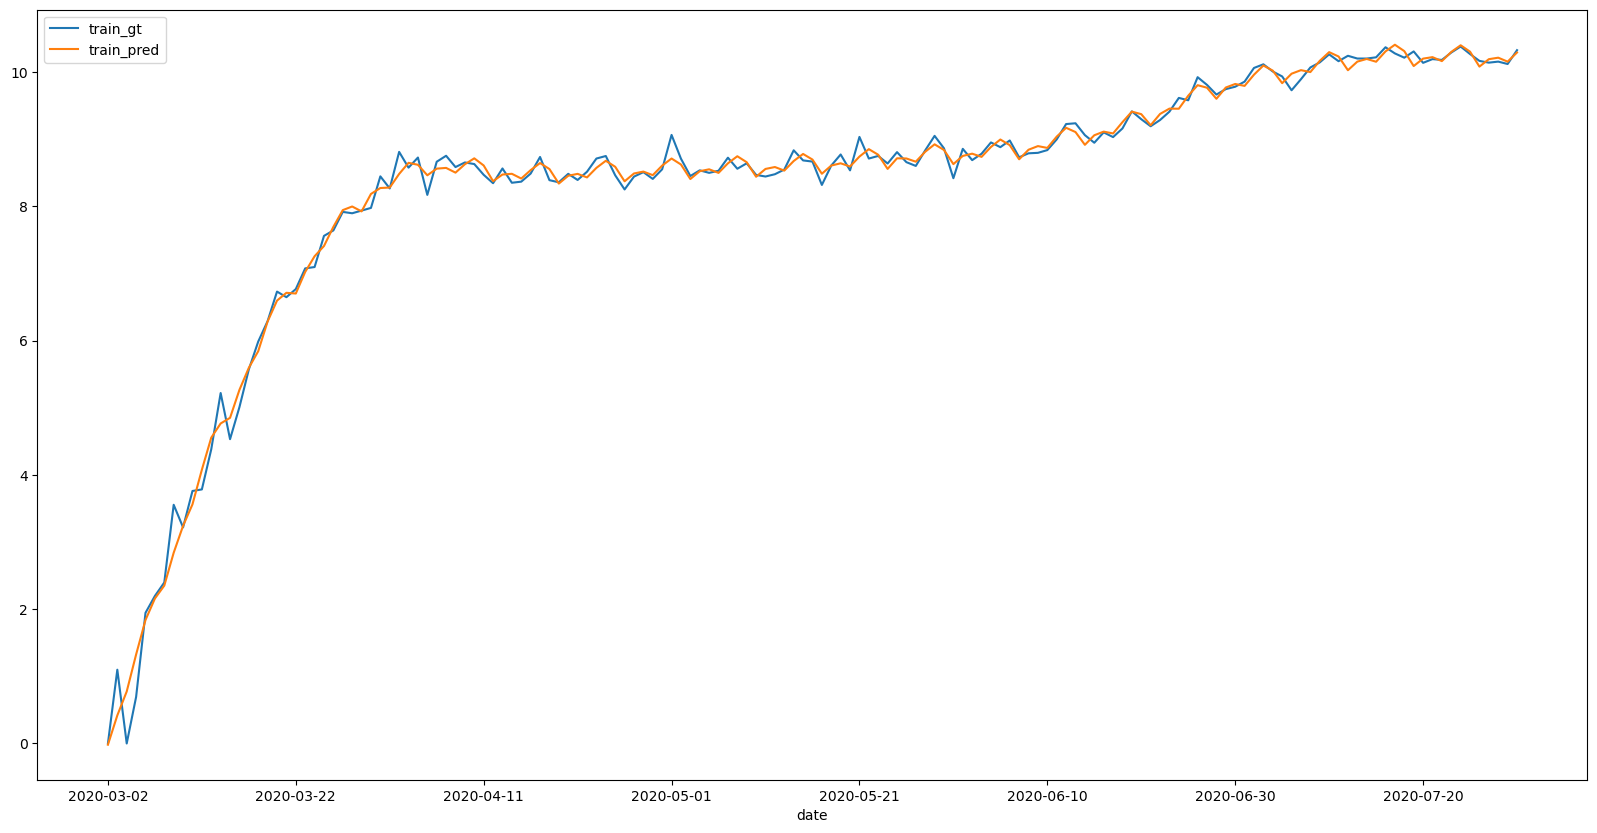

In [684]:
# Visualizing train data fitted values
s_train_pred = s_tuned_forecast.iloc[:151]["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

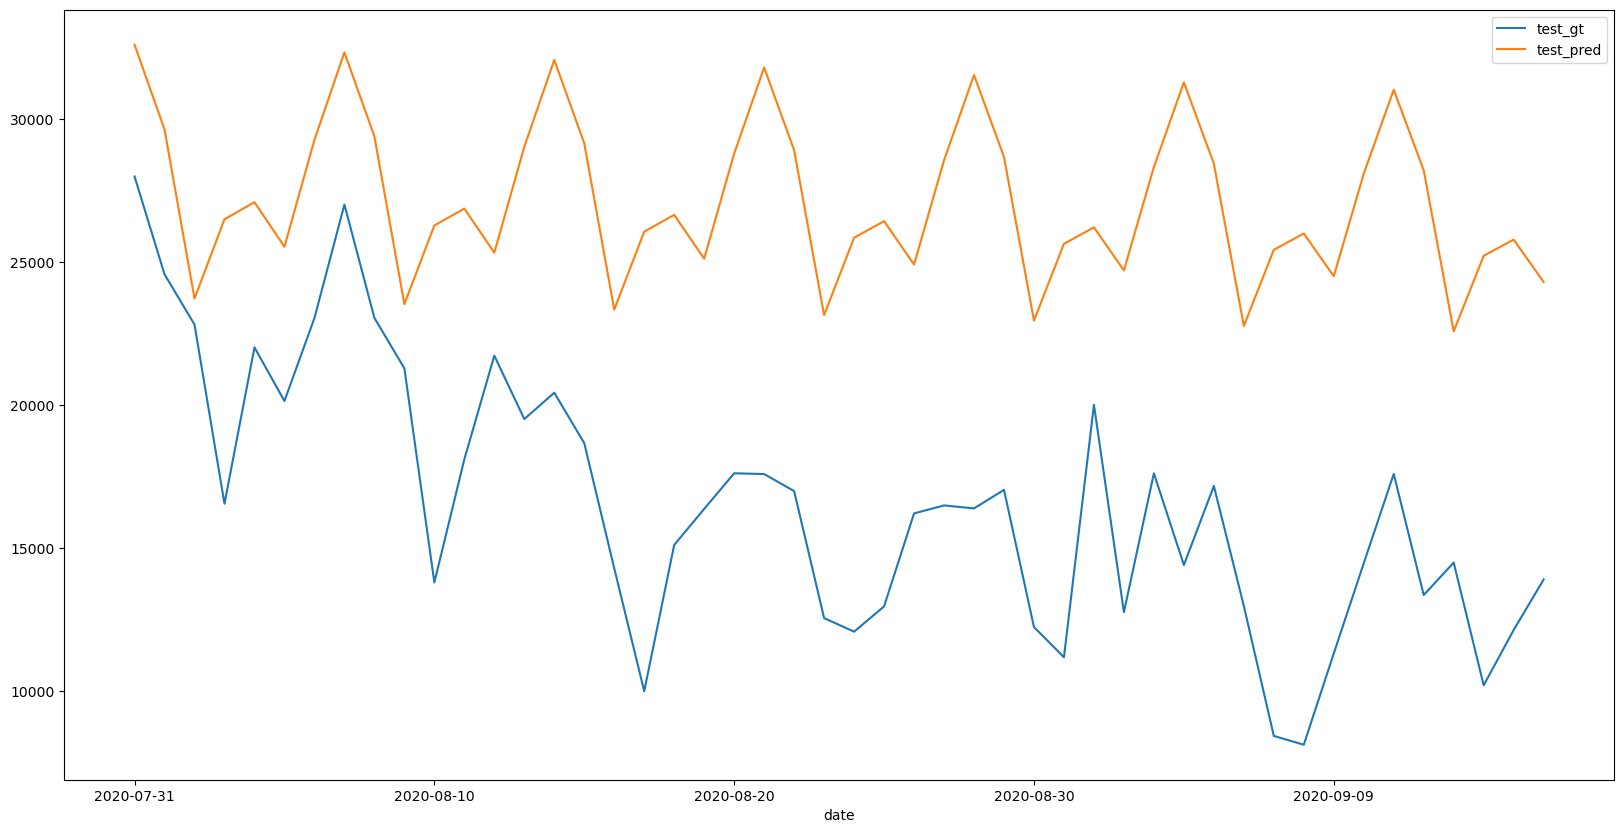

In [685]:
# Visualizing test data fitted values
s_test_pred = s_tuned_forecast.iloc[151:]["yhat"]
s_test_pred = np.exp(s_test_pred)
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [686]:
# MAE on test data
mean_absolute_error(s_test_plot, s_test_pred)

10508.369347528373

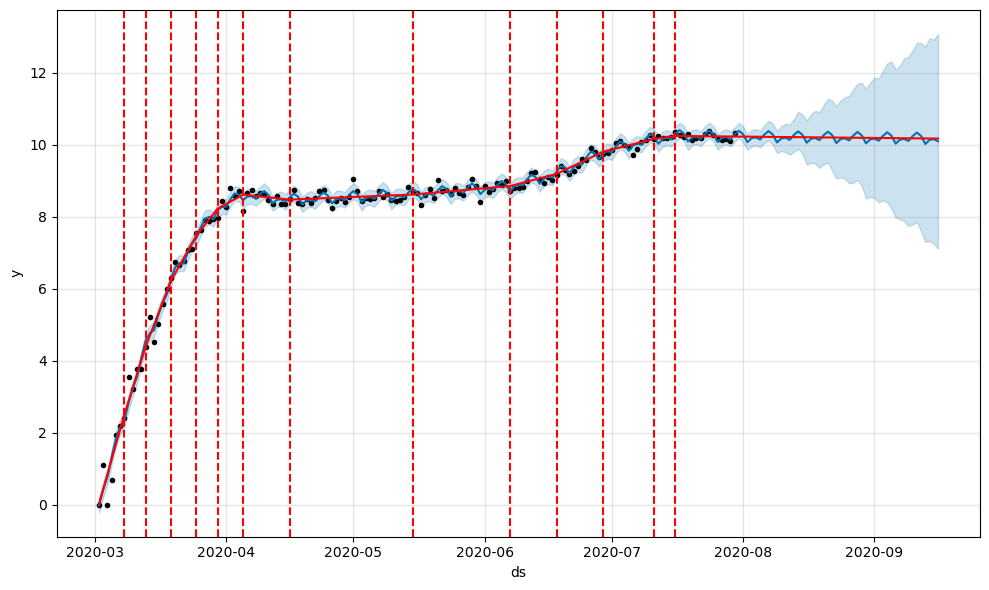

In [687]:
# Visualizing change points
fig = s_tuned_prophet.plot(s_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), s_tuned_prophet, s_tuned_forecast)